In [7]:
import requests
import random
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import sqlite3
import time
import urllib

In [8]:
# Autores ficticios 

AUTORES_FICTICIOS = [
    "Juan Pérez", "María González", "Carlos Benítez", "Ana Rodríguez", "Luis Fernández",
    "Sofía Martínez", "Miguel López", "Valeria Ramírez", "Diego Acosta", "Laura Cáceres",
    "Fernando Duarte", "Paula Ortiz", "Ricardo Silva", "Natalia Romero", "Andrés Villalba",
    "Marcos Rojas", "Lucía Torres", "Jorge Mendoza", "Cecilia Franco", "Héctor Cabrera",
    "Patricia Aguirre", "Tomás Medina", "Carla Vega", "Esteban Morales", "Verónica Paredes",
    "Alberto Núñez", "Gabriela Suárez", "Sebastián Figueroa", "Monica Castro", "Raúl Vargas",
    "Isabel Soto", "Renato Salinas", "Lorena Ayala", "Pablo Riquelme", "Camila Espínola",
    "Santiago Cabrera", "Juliana Duarte", "Javier Peralta", "Mariana Ríos", "Diego Quiñónez",
    "Adriana Villanueva", "Felipe Chamorro", "Natalia Acuña", "Hugo Benítez", "Claudia Morel",
    "Ricardo Espinoza", "Viviana Ortiz", "Martín Cardozo", "Daniela Giménez", "Gonzalo Rojas",
    "Antonio Ledesma", "Elena Caballero", "Víctor Herrera", "Mónica Peralta", "Ignacio Farias",
    "Silvia Campos", "Alfonso Paredes", "Carolina Gutiérrez", "Joaquín Aguirre", "Luz Martínez",
    "Emiliano Torres", "Patricia Salazar", "Rodrigo Molina", "María Eugenia Díaz", "Fabián Rojas",
    "Camila Castillo", "Guillermo Bravo", "Fernanda Ramírez", "Andrés Molina", "Natalia Vega",
    "Tomás Ruiz", "Lorena Mendoza", "Diego Fernández", "Isabel López", "Juan Carlos Paredes",
    "Valentina Ríos", "Santiago Morales", "Claudia Pérez", "Ricardo Herrera", "Lucía Benítez",
    "Héctor Riquelme", "Ana Sofía Romero", "Martín González", "Daniela Cabrera", "Javier Duarte",
    "Paula Ramírez", "Fernando Castro", "Carla Ortiz", "Sebastián Silva", "Verónica López",
    "Andrés Aguirre", "Mariana Núñez", "Diego Fernández", "Natalia Torres", "Luis Rojas",
    "Sofía Cabrera", "Miguel Herrera", "Laura Benítez", "Ricardo Martínez", "Valeria Peralta",
    "Jorge Ramírez", "Cecilia Vargas", "Hugo Riquelme", "Isabel Duarte", "Tomás Gutiérrez"
]

def asignar_autor_aleatorio():
    """Devuelve un autor ficticio al azar."""
    return random.choice(AUTORES_FICTICIOS)


In [9]:
URL_BASE = "https://books.toscrape.com/"
DB_NAME = "libros_escrapeados.db"

In [ ]:
# Solicitud a la pagina que vamos a scrapear

response = requests.get(URL_BASE)

print(response)

<Response [200]>


In [11]:
# Verificamps que la solicitud fue exitosa

if response.status_code != 200:
    print(f"Error al acceder a la pagina: {response.status_code}")
    exit()

In [12]:
# Imprimimos response en forma de texto
print(response.text)

<!DOCTYPE html>
<!--[if lt IE 7]>      <html lang="en-us" class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->
<!--[if IE 7]>         <html lang="en-us" class="no-js lt-ie9 lt-ie8"> <![endif]-->
<!--[if IE 8]>         <html lang="en-us" class="no-js lt-ie9"> <![endif]-->
<!--[if gt IE 8]><!--> <html lang="en-us" class="no-js"> <!--<![endif]-->
    <head>
        <title>
    All products | Books to Scrape - Sandbox
</title>

        <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
        <meta name="created" content="24th Jun 2016 09:29" />
        <meta name="description" content="" />
        <meta name="viewport" content="width=device-width" />
        <meta name="robots" content="NOARCHIVE,NOCACHE" />

        <!-- Le HTML5 shim, for IE6-8 support of HTML elements -->
        <!--[if lt IE 9]>
        <script src="//html5shim.googlecode.com/svn/trunk/html5.js"></script>
        <![endif]-->

        
            <link rel="shortcut icon" href="static/oscar/favicon.

In [13]:
#Conectamos a la base de datos
conn = sqlite3.connect(DB_NAME)
conn.execute("PRAGMA foreign_keys = ON;")
cursor = conn.cursor()

# **Creación de tablas en la base de datos**

In [14]:
cursor.executescript(
"""
DROP TABLE IF EXISTS libro_autor;
DROP TABLE IF EXISTS libro;
DROP TABLE IF EXISTS autor;                     
DROP TABLE IF EXISTS categoria;

CREATE TABLE categoria (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    nombre TEXT UNIQUE
);
                     
CREATE TABLE autor (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    nombre TEXT UNIQUE
);

CREATE TABLE libro (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    titulo TEXT,
    precio REAL,
    rating INTEGER,
    disponibilidad TEXT,
    categoria_id INTEGER,
    FOREIGN KEY (categoria_id) REFERENCES categoria(id)
);
                     
CREATE TABLE libro_autor (
    libro_id INTEGER,
    autor_id INTEGER,
    PRIMARY KEY (libro_id, autor_id),
    FOREIGN KEY (libro_id) REFERENCES libro(id),
    FOREIGN KEY (autor_id) REFERENCES autor(id)
);
                     
"""
)
conn.commit()
print("Tablas creadas")

Tablas creadas


# **Diagrama UML**

![Diagrama UML.png](<attachment:Diagrama UML.png>)
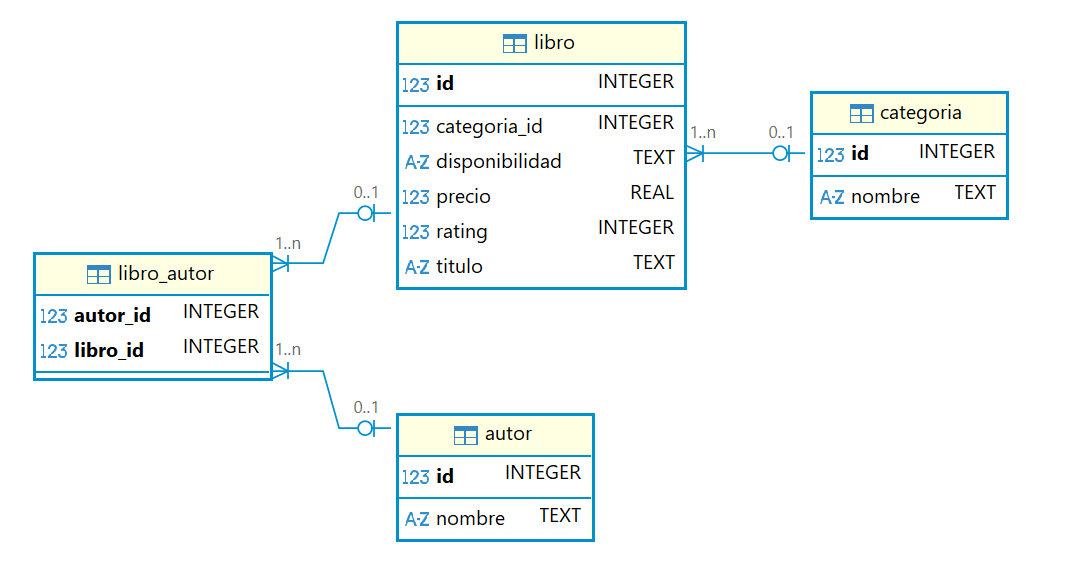

# **Funciones de Scraping**


In [ ]:
def obtener_soup(url):
    # Retorna un objeto BeautifulSoup de una URL.
    resp = requests.get(url)    
    return BeautifulSoup(resp.content, "html.parser", from_encoding="utf-8")

def get_categorias():
    # Para listar todas las categorías del la página principal
    soup = obtener_soup(URL_BASE)
    categorias = []

    for li in soup.select(".nav-list ul li a"): 
        nombre_categoria = li.text.strip()
        link = urllib.parse.urljoin(URL_BASE, li["href"])
        categorias.append((nombre_categoria, link))
    return categorias


def get_libros_de_categoria(url_categoria):
      
    libros_data = [] 
    rating_dict = {"One": 1, "Two": 2, "Three": 3, "Four": 4, "Five": 5} 

    while True:  
        print(f"  ... Scrapeando página: {url_categoria}")
        soup = obtener_soup(url_categoria) 

        # Iterar sobre cada "product_pod" (cada libro en la grilla)
        for libro in soup.select("article.product_pod"): 
            try:
                # Extraer título (del atributo 'title' del enlace)
                titulo = libro.select_one("h3 a")["title"]

                # Extraer precio
                precio_texto = libro.select_one(".price_color").text.strip()
                precio = float(precio_texto.replace("£", "").replace(",", "."))

                # Extraer Rating 
                rating_tag = libro.select_one(".star-rating") # Extrae el tag que contiene el rating
                # La clase es una lista, ej: ["star-rating", "Three"]. Queremos el segundo item.
                rating_texto = rating_tag["class"][1] # Extraer el texto del rating
                rating = rating_dict.get(rating_texto, 0) # Convertir "Three" a 3
                
                # Extraer disponibilidad ("In stock")
                disponibilidad = libro.select_one(".availability").text.strip()

                # Guardar los datos
                libros_data.append({
                    "titulo": titulo,
                    "precio": precio,
                    "rating": rating,
                    "disponibilidad": disponibilidad
                })
            except Exception as e:
                print(f"Error parseando un libro de la grilla: {e}")

        pagina_siguiente = soup.select_one(".next a") # Buscar el botón "next" para paginación

        if pagina_siguiente:
            # Si hay página siguiente, actualiza la URL para el próximo loop
            url_categoria = urljoin(url_categoria, pagina_siguiente["href"])
            time.sleep(0.2) 
        else:
            break

    return libros_data 

# **FUNCIONES PARA INSERTAR DATOS EN LA BASE DE DATOS (DML)**

In [ ]:
def insert_categoria(nombre):
    cursor.execute("INSERT OR IGNORE INTO categoria (nombre) VALUES (?)", (nombre,))
    conn.commit()
    cursor.execute("SELECT id FROM categoria WHERE nombre=?", (nombre,))
    return cursor.fetchone()[0] 

def insert_autor(nombre):
    cursor.execute("INSERT OR IGNORE INTO autor (nombre) VALUES (?)", (nombre,))
    conn.commit()
    cursor.execute("SELECT id FROM autor WHERE nombre=?", (nombre,))
    return cursor.fetchone()[0] 

def insert_libro(data, categoria_id):
    cursor.execute(
        """
        INSERT INTO libro (titulo, precio, rating, disponibilidad, categoria_id)
        VALUES (?, ?, ?, ?, ?) 
        """,
        (
            data["titulo"],
            data["precio"],
            data["rating"],
            data["disponibilidad"],
            categoria_id, 
        )
    )
    conn.commit()
    return cursor.lastrowid 

def link_libro_autor(libro_id, autor_id):
    cursor.execute(
        "INSERT OR IGNORE INTO libro_autor (libro_id, autor_id) VALUES (?, ?)",
        (libro_id, autor_id)
    )
    conn.commit()